# Imputation of Business Features in Pandas DataFrame
Ryan Skinner, December 8, 2018

***

At this point, we have all restaurant business records, in addition to their attributes that have high support based on prior analysis, in a (serialized and compressed) Pandas DataFrame.

Our next task is to impute missing values for business categories and attributes. For categories, NaNs can be replaced with false/0 values. The imputation strategy is a little more complicated and case-specific for attributes.

In [1]:
import pandas as pd
import json
import re
import string
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from pprint import pprint
from progressbar import ProgressBar
%matplotlib inline

Load the main restaurant features DataFrame!

In [2]:
df = pd.read_pickle('restaurants_vanilla.pkl.bz2')

## Quick Visualization of Restaurant Location

We will need to isolate restaurants in Las Vegas at some point; let's visualize the lat-lon coordinates of restaurants to see how easy it will be to categorize a restaurant's city based on distance to a city center. This is necessary since some restaurants are located within the metropolitan area of a "big city" but the actual city where they are listed is a suburb.

Text(0.95,0.05,'Heatmap of Restaurant Locations')

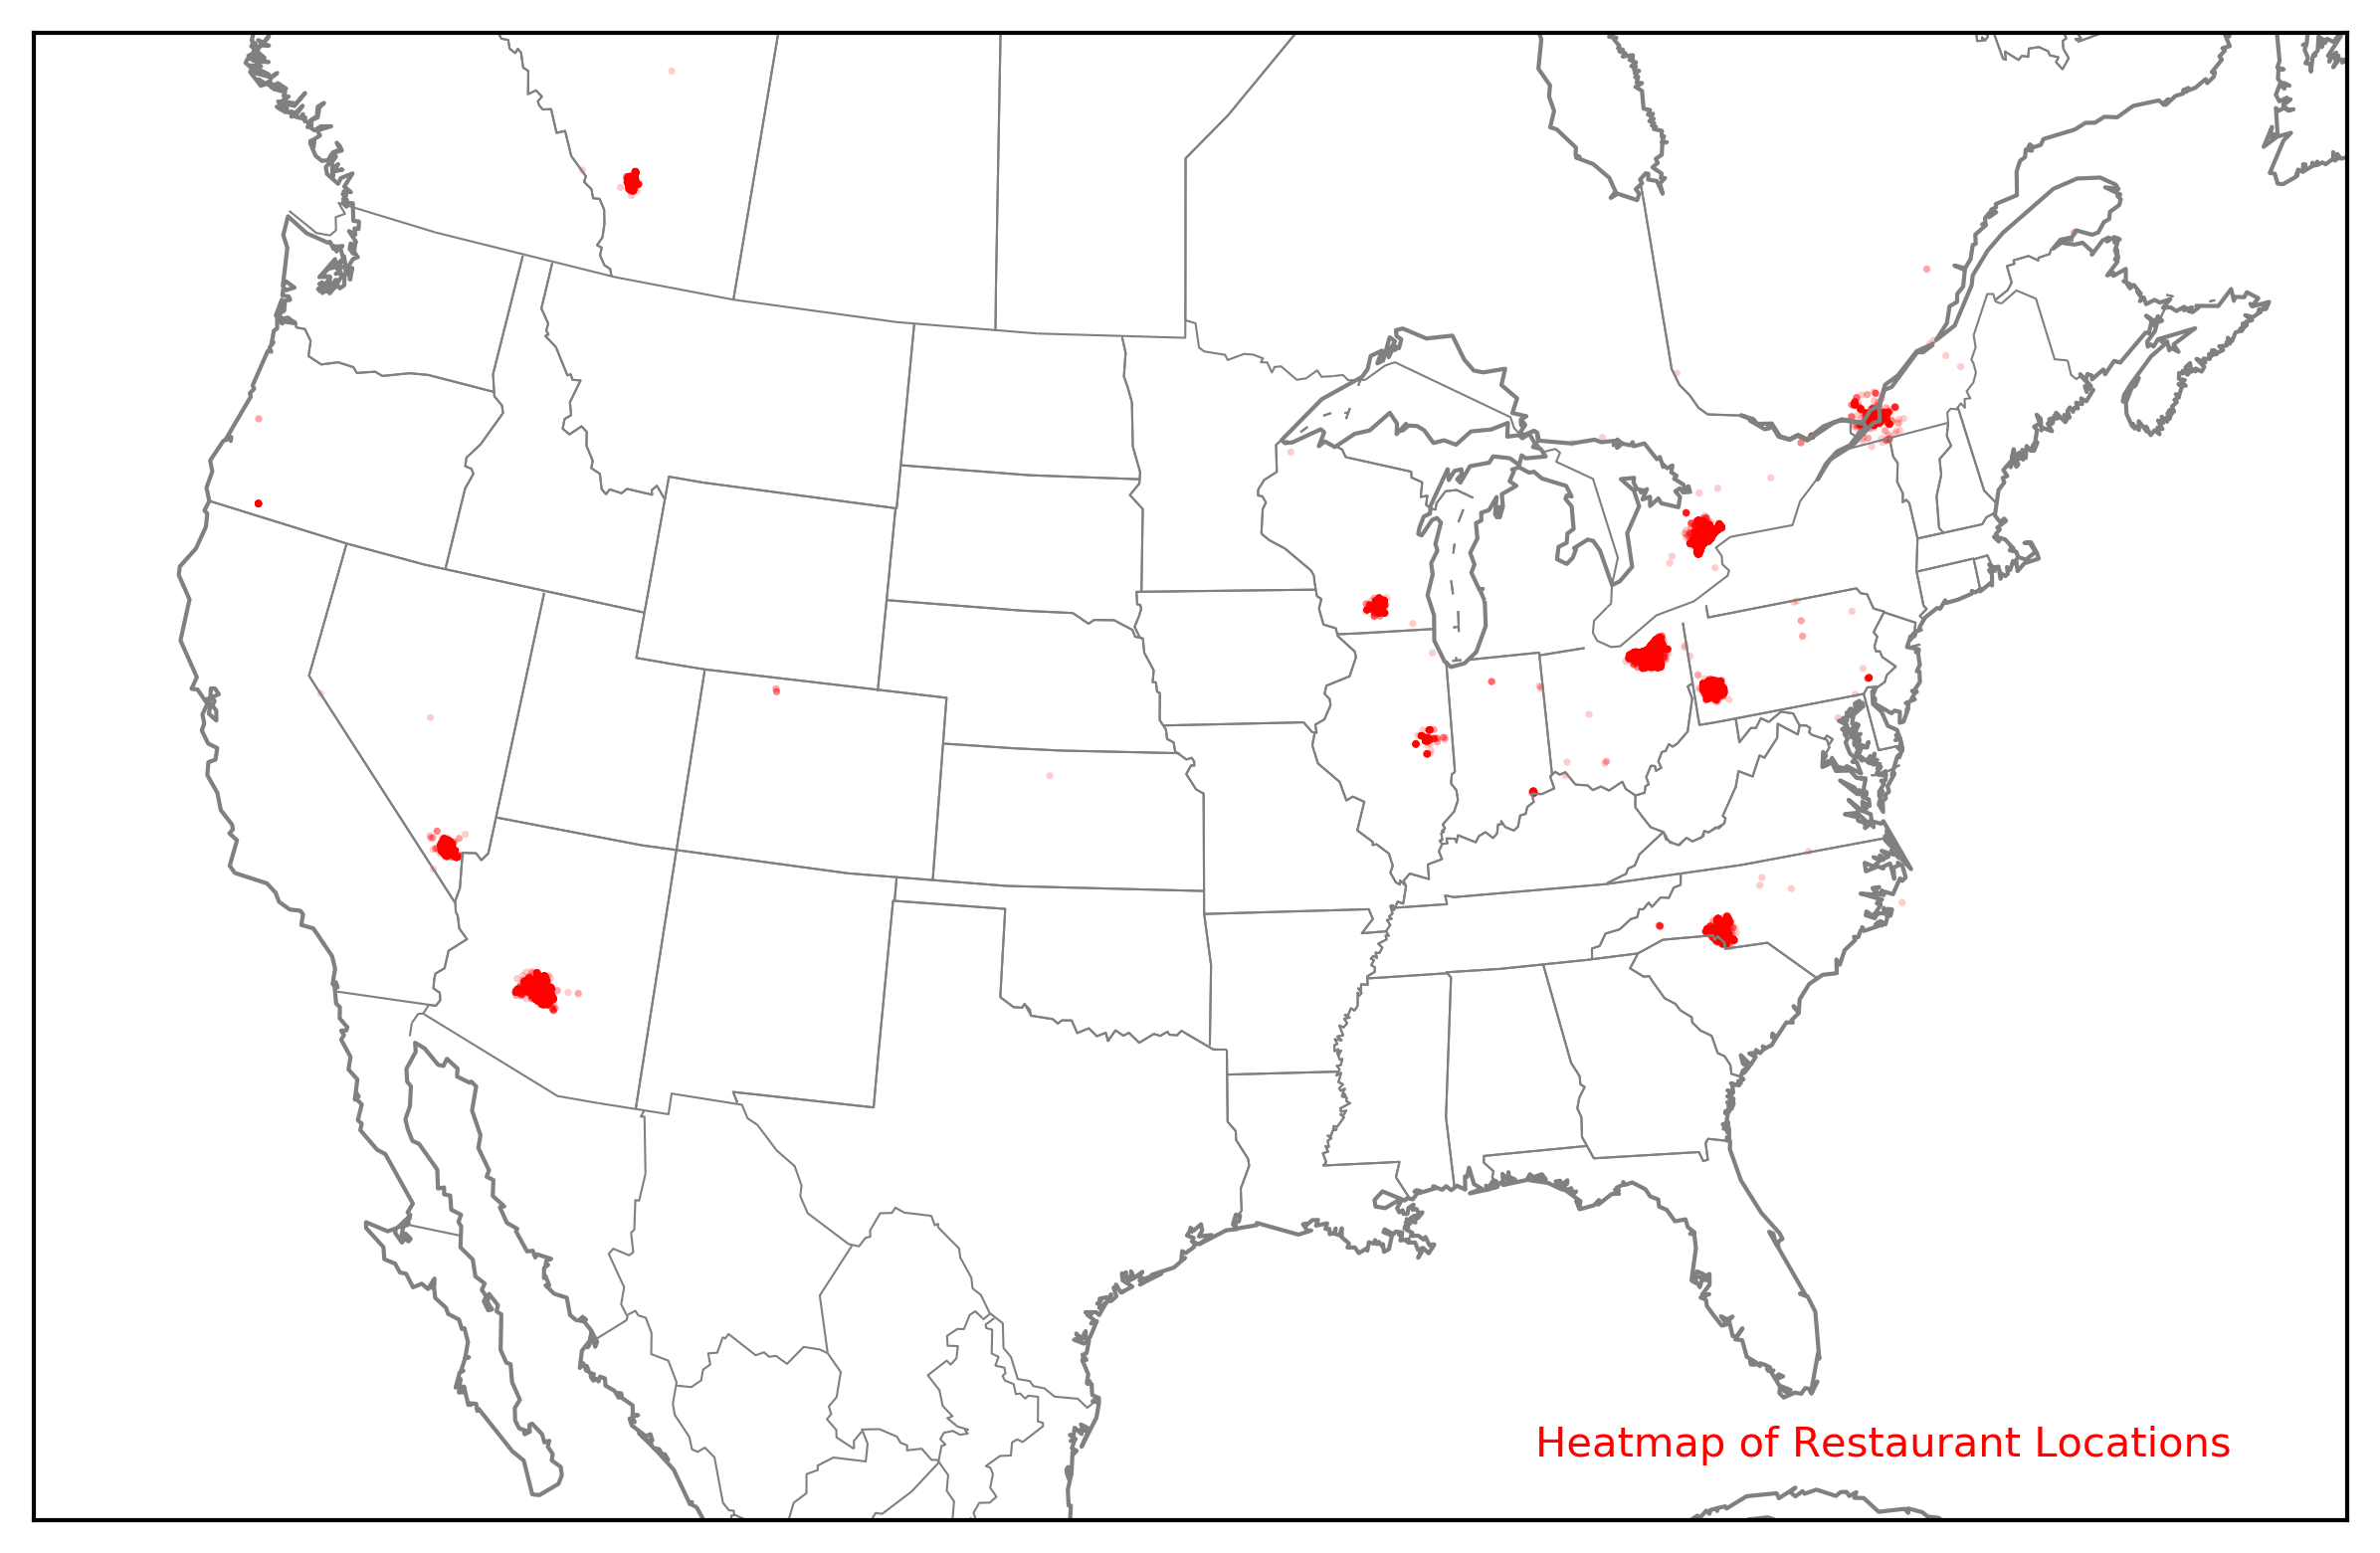

In [5]:
from mpl_toolkits.basemap import Basemap
import warnings
warnings.filterwarnings('ignore')

fig = plt.figure(figsize=(10, 10), dpi=300)

m = Basemap(projection='lcc', resolution='l', area_thresh=1e5, width=5.6e6, height=3.6e6, lat_0=39.5, lon_0=-95)
m.drawmapboundary(fill_color='white')
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')

m.scatter(df.longitude.tolist(), df.latitude.tolist(), latlon=True, alpha=0.2, s=3, c='r', edgecolors='none')
plt.text(0.95, 0.05, 'Heatmap of Restaurant Locations', color='r',
         ha='right', va='center', transform=plt.gca().transAxes)

## Imputing Missing Business Categories + Attributes

We start with business categories, or `bizcategory_*` features. If a business does not have a particular category marked, we impute its value as a zero. This is straightforward.

In [6]:
for bizcategory in [cat for cat in df.columns if 'bizcategory_' in cat]:
    df[bizcategory].fillna(0, inplace=True)

Now let's look at what numerical business attributes we need to impute. Below, we display a summary of attributes who do not have full support over the dataset (yet).

In [7]:
df_tmp = df.describe().transpose().sort_values('count').sort_index().sort_values('max')
df_tmp = df_tmp[df_tmp['count'] < 57173]
df_tmp

,count,mean,std,min,25%,50%,75%,max
bizattribute_bikeparking,38143.0,0.759117,0.427625,0.0,1.0,1.0,1.0,1.0
bizattribute_businessacceptscreditcards,48451.0,0.958474,0.199507,0.0,1.0,1.0,1.0,1.0
bizattribute_caters,34180.0,0.539350,0.498456,0.0,0.0,1.0,1.0,1.0
bizattribute_goodforkids,49863.0,0.833624,0.372421,0.0,1.0,1.0,1.0,1.0
bizattribute_goodformeal_breakfast,46925.0,0.090719,0.287212,0.0,0.0,0.0,0.0,1.0
bizattribute_goodformeal_brunch,46925.0,0.090123,0.286360,0.0,0.0,0.0,0.0,1.0
bizattribute_goodformeal_dessert,46925.0,0.048652,0.215142,0.0,0.0,0.0,0.0,1.0
bizattribute_goodformeal_dinner,46925.0,0.390325,0.487828,0.0,0.0,0.0,1.0,1.0
bizattribute_goodformeal_latenight,46925.0,0.057091,0.232019,0.0,0.0,0.0,0.0,1.0
bizattribute_goodformeal_lunch,46925.0,0.456793,0.498135,0.0,0.0,0.0,1.0,1.0


We need to impute quite a few attributes. For the ones that are coded as true=1, false=0, we simply put 0.5 as our "unknown" value.

In [8]:
for ind in df_tmp[(df_tmp['min'] == 0) & (df_tmp['max'] == 1)].index:
    df[ind].fillna(0.5, inplace=True)

What about for the ordinal attributes, below?

In [9]:
df_tmp = df.describe().transpose().sort_values('count').sort_index().sort_values('max')
df_tmp = df_tmp[df_tmp['count'] < 57173]
df_tmp

,count,mean,std,min,25%,50%,75%,max
bizattribute_alcohol,43786.0,0.918010,0.922603,0.0,0.0,1.0,2.0,2.0
bizattribute_restaurantsattire,48164.0,0.033594,0.194160,0.0,0.0,0.0,0.0,2.0
bizattribute_noiselevel,40896.0,0.909869,0.648977,0.0,1.0,1.0,1.0,3.0
bizattribute_restaurantspricerange2,51111.0,1.676117,0.625056,1.0,1.0,2.0,2.0,4.0


In this case, we fill missing value with the global mean.

In [10]:
for ind in df_tmp.index:
    df[ind].fillna(df_tmp.loc[ind, 'mean'], inplace=True)

In [11]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
bizattribute_alcohol,57173.0,0.918010,0.807395,0.000000,0.000000,0.918010,2.000000,2.000000
bizattribute_bikeparking,57173.0,0.672870,0.370008,0.000000,0.500000,1.000000,1.000000,1.000000
bizattribute_businessacceptscreditcards,57173.0,0.888531,0.246791,0.000000,1.000000,1.000000,1.000000,1.000000
bizattribute_caters,57173.0,0.523525,0.385886,0.000000,0.000000,0.500000,1.000000,1.000000
bizattribute_goodforkids,57173.0,0.790968,0.365206,0.000000,0.500000,1.000000,1.000000,1.000000
bizattribute_goodformeal_breakfast,57173.0,0.164081,0.303889,0.000000,0.000000,0.000000,0.500000,1.000000
bizattribute_goodformeal_brunch,57173.0,0.163591,0.303347,0.000000,0.000000,0.000000,0.500000,1.000000
bizattribute_goodformeal_dessert,57173.0,0.129554,0.260691,0.000000,0.000000,0.000000,0.000000,1.000000
bizattribute_goodformeal_dinner,57173.0,0.409984,0.443947,0.000000,0.000000,0.000000,1.000000,1.000000
bizattribute_goodformeal_latenight,57173.0,0.136481,0.270266,0.000000,0.000000,0.000000,0.000000,1.000000


All of our features are done now! The only remaining ones (below) are features that we will not be using in our models.

In [12]:
df.select_dtypes(exclude='float64').dtypes

address         object
city            object
hours           object
name            object
neighborhood    object
postal_code     object
state           object
dtype: object

Finally, serialize the dataframe for ease of sharing with group members.

In [13]:
df.to_pickle('restaurants_imputed.pkl.bz2')

## TODO

- We could impute certain features based on mean value within all business categories that restaurant has, but we want to get models built first before playing with this extension.